In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import matplotlib.patches as patches

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
from torchvision import transforms

files_dir = '../input/wadhwani-ai-bollworm/images_resized/images_resized'

In [2]:
image_boxes = pd.read_csv('../input/wadhwani-ai-bollworm/images_boxes_500_low200.csv')
image_boxes.head()

,image_id,worm_type,min_X,min_Y,max_X,max_Y,width,height
0,id_8ada71185e18dc8838b4925b.jpg,1,387.039388,25.515951,403.465169,48.479818,3072,3072
1,id_8ada71185e18dc8838b4925b.jpg,1,116.437174,198.805339,152.965495,214.791667,3072,3072
2,id_8ada71185e18dc8838b4925b.jpg,2,183.875326,253.590495,253.857422,320.035807,3072,3072
3,id_bc86d3cfd0c0463fa5cae33e.jpg,2,217.959535,256.201678,261.277050,299.969143,4000,3000
4,id_bc86d3cfd0c0463fa5cae33e.jpg,2,270.267196,279.384042,292.782107,325.378321,4000,3000


In [3]:
image_boxes.shape

(117041, 8)

In [4]:
# Send train=True fro training transforms and False for val/test transforms
trans = transforms.Compose([transforms.ToTensor()])
def get_transform(train):
    
    if train:
        return A.Compose([
                            A.HorizontalFlip(0.5),
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensorV2(p=1.0) 
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [5]:
# defining the files directory and testing directory

class BollwormDataset(torch.utils.data.Dataset):

    def __init__(self, files_dir, width, height, transforms=None):

        
        self.transforms = transforms
        self.files_dir = files_dir
        self.images_bboxes=pd.read_csv('../input/wadhwani-ai-bollworm/images_boxes_500_low200.csv')
        self.height = height
        self.width = width
        

        self.imgs = [image for image in self.images_bboxes['image_id']]        
        
        # classes: 0 index is reserved for background
        self.classes = [_, 'abw','pbw']

    def __getitem__(self, idx):

        img_name = self.imgs[idx]
 
        image_path = os.path.join(self.files_dir, img_name)

        
        m = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(m, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # diving by 255
        img_res /= 255.0
        
        if self.transforms is not None:  #Apply transformation
            img_res = self.transforms(img_res)
            
        list_boxes =[]
        list_labels = []
        boxes = []
        labels = []
        
        # cv2 image gives size as height x width
        wt = m.shape[1]
        ht = m.shape[0]
        
        #labels.append(images_bboxes['worm_type'][idx])    
        # bounding box
        list_boxes = self.images_bboxes[['min_X','min_Y','max_X','max_Y']][self.images_bboxes['image_id'] == self.images_bboxes['image_id'][idx]].values.tolist()
        list_labels = self.images_bboxes[['worm_type']][self.images_bboxes['image_id'] == self.images_bboxes['image_id'][idx]].values.tolist()
        L1 = [x[0] for x in list_labels]
        
        for i in range(len(list_boxes)):
            xmin = list_boxes[i][0]
            xmax = list_boxes[i][2]
            ymin = list_boxes[i][1]
            ymax = list_boxes[i][3]

            
            boxes.append([xmin, ymin, xmax, ymax])
        
        
        # convert boxes into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        labels = torch.as_tensor(L1, dtype=torch.int64)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        target["image_id"] = torch.tensor([idx])


        '''if self.transforms:
            
            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = target["labels"])
            
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes']) '''
            
            
            
            
        return img_res, target,img_name 

    def __len__(self):
        return len(self.images_bboxes['image_id'])

tensor([215.8654, 242.4279, 243.7500, 260.6971])
tensor([183.3333, 263.2212, 252.4038, 331.2500])
tensor([213.6218,  98.9183, 295.3526, 143.2692])
tensor([111.2179, 281.7308, 180.7692, 350.6010])
tensor([215.0641, 296.5144, 293.9102, 342.9087])
tensor([134.7756, 259.3750, 187.1795, 318.7500])


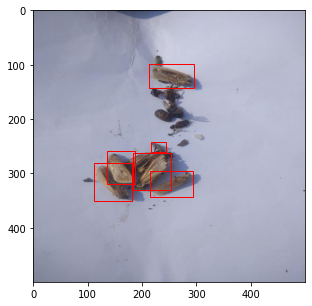

In [6]:
# Function to visualize bounding boxes in the image

def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        print(box)
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 1,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()
    
# plotting the image with bboxes. Feel free to change the index
img, target,_ = BollwormDataset(files_dir,500,500)[50]
plot_img_bbox(img, target)

In [7]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
        

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [8]:
num_classes = 3  # 2 classes + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [9]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [10]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = BollwormDataset(files_dir,500,500,trans)
valid_dataset = BollwormDataset(files_dir,500,500,trans)


# split the dataset in train and valid set
torch.manual_seed(1)
indices = torch.randperm(len(train_dataset)).tolist()

# train test split
test_split = 0.2
tsize = int(len(train_dataset) * test_split)

train_dataset = Subset(train_dataset, indices[:-tsize])
valid_dataset = Subset(valid_dataset, indices[-tsize:])


train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [12]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

num_epochs = 1

In [13]:
loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets,_ in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")

Iteration #50 loss: 1.1566143035888672
Iteration #100 loss: 0.9909119009971619
Iteration #150 loss: 0.9179059863090515
Iteration #200 loss: 1.0816302299499512
Iteration #250 loss: 0.9425476789474487
Iteration #300 loss: 0.995457112789154
Iteration #350 loss: 0.9710943698883057
Iteration #400 loss: 1.0210611820220947
Iteration #450 loss: 0.9396131634712219
Iteration #500 loss: 0.9452285170555115
Iteration #550 loss: 1.6086010932922363
Iteration #600 loss: 0.8799313902854919
Iteration #700 loss: 0.8772604465484619
Iteration #750 loss: 1.161983847618103
Iteration #800 loss: 0.9680302143096924
Iteration #850 loss: 0.759728193283081
Iteration #900 loss: 0.8081573247909546
Iteration #950 loss: 0.898993730545044
Iteration #1000 loss: 0.8054624199867249
Iteration #1050 loss: 0.8734164834022522
Iteration #1100 loss: 0.8823456764221191
Iteration #1150 loss: 0.8791903853416443
Iteration #1200 loss: 0.910032331943512
Iteration #1250 loss: 0.8006833791732788
Iteration #1300 loss: 0.7652677297592163

In [14]:
# the function takes the original prediction and the iou threshold.

def apply_nms(orig_prediction, iou_thresh=0.3):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

In [20]:
# pick one image from the test set
img, target, image_ids = valid_dataset[5]
# put the model in evaluation mode
model.eval()
cpu_device = torch.device("cpu")
with torch.no_grad():
    prediction = model([img.to(device)])
    prediction = [{k: v.to(cpu_device) for k, v in t.items()} for t in prediction]
    
print('predicted #boxes: ', len(prediction[0]['labels']))
print('real #boxes: ', len(target['labels']))

predicted #boxes:  8
real #boxes:  6


EXPECTED OUTPUT
tensor([287.8173, 231.4904, 329.1878, 244.9519])
tensor([339.0863, 230.0481, 387.5634, 250.3606])
tensor([153.8071, 217.9087, 197.9695, 234.1346])
tensor([ 92.6396, 211.1779, 141.1167, 226.6827])
tensor([322.0812, 179.4471, 369.0355, 191.5865])
tensor([183.7563, 273.3173, 225.1269, 293.5096])


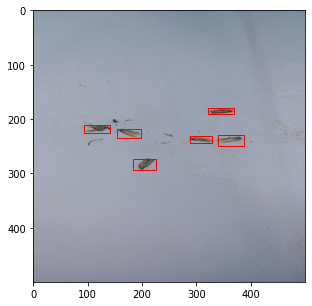

In [21]:
print('EXPECTED OUTPUT')
plot_img_bbox(torch_to_pil(img), target)

MODEL OUTPUT
tensor([336.7144, 231.7906, 386.1801, 244.6580])
tensor([191.3351, 271.4901, 225.4938, 295.7434])
tensor([149.1560, 216.1548, 200.1228, 234.9000])
tensor([ 92.5417, 210.9484, 140.8626, 223.5910])
tensor([321.3422, 179.0108, 371.1296, 191.0290])
tensor([301.3935, 233.5542, 334.1101, 243.8003])
tensor([285.3123, 232.6067, 327.8419, 242.8847])
tensor([319.2411, 174.2404, 375.3389, 196.1545])


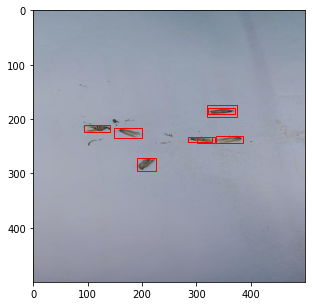

In [22]:
print('MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), prediction[0])

NMS APPLIED MODEL OUTPUT
tensor([336.7144, 231.7906, 386.1801, 244.6580])
tensor([191.3351, 271.4901, 225.4938, 295.7434])
tensor([149.1560, 216.1548, 200.1228, 234.9000])
tensor([ 92.5417, 210.9484, 140.8626, 223.5910])
tensor([321.3422, 179.0108, 371.1296, 191.0290])
tensor([301.3935, 233.5542, 334.1101, 243.8003])


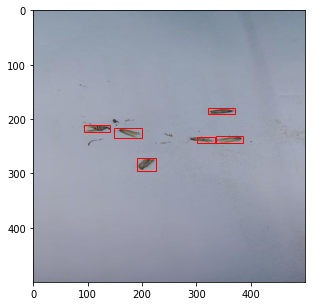

In [26]:
nms_prediction = apply_nms(prediction[0], iou_thresh=0.2)
print('NMS APPLIED MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), nms_prediction)

In [34]:
torch.save(model.state_dict(), '200fasterrcnn_resnet50_fpn.pth')